In [1]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction


# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# USILaughs

## Cognitive Load Info

In [2]:
path_to_experiment_info: str = "../data.nosync/usilaughs/all_experimento_info.csv"
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=1)

## Physiological Data

In [3]:
eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/67 [00:00<?, ?it/s]

528

In [4]:
users = get_all_users(eda_data)
sessions_all = ["experiment"]
output_folder: str = "../visualizations/"
for user in tqdm(sorted(users), desc="Plotting user data", colour="red"):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data={"EDA": eda_data},
            user_id=user,
            session_id=session,
            dataset="usi_laughs",
            experiment_info=experiment_info.to_df(),
            eda_type="mixed-EDA",
            output_folder=output_folder
        )


Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

In [5]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())

In [6]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [7]:
segment_size_in_secs = 4
eda_sample_rate = 4

segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate
experiment_info_as_dict = experiment_info.to_dict()

In [8]:
(
    values_left,
    values_right,
    labels_left,
    labels_right,
    groups_left,
    groups_right,
) = segment(
    data=eda_data,
    experiment_info_as_dict=experiment_info_as_dict,
    segment_size_in_sampling_rate=segment_size_in_sampling_rate,
    segment_size_in_secs=segment_size_in_secs,
    data_sample_rate=eda_sample_rate,
)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

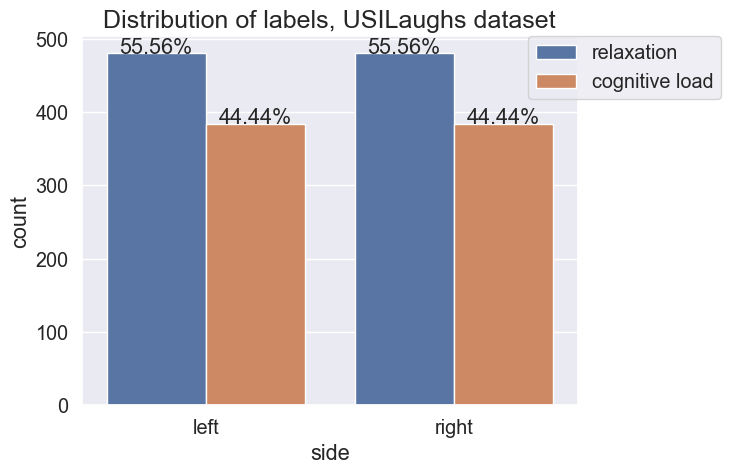

In [9]:
counts = {
    "left": Series(labels_left).value_counts(),
    "right": Series(labels_right).value_counts(),
}
counts = DataFrame(counts).unstack().reset_index()
counts.columns = ["side", "label", "count"]
counts["label"] = counts["label"].map({0: "relaxation", 1: "cognitive load"})
plot_binary_labels(
    counts=counts,
    title="Distribution of labels, USILaughs dataset",
    dataset_name="usilaughs",
    output_folder="../visualizations/"
)


The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [10]:
from numpy import stack

features_left: ndarray = stack(values_left)
features_right: ndarray = stack(values_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

In [11]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(864, 16)
labels_left.shape=(864,)
groups_left.shape=(864,)


## ML Prediction

#### LX v LX

In [12]:
from numpy import ndarray


def run_fold_dl(
    train_index: ndarray,
    test_index: ndarray,
    x_resampled: ndarray,
    y_resampled: ndarray,
    random_state_classifier: int,
    dl_model,
):
    x_train, x_test = x_resampled[train_index], x_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    
    result = dl_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))
    return result


In [13]:
from keras_resnet.models._1d import ResNet1D

In [22]:
import keras_resnet.blocks
import keras_resnet.models
import keras

shape, classes = (features_right.shape[1]), 1

x = keras.layers.Input(shape)

blocks = [2, 2, 2, 2]

block = keras_resnet.blocks.basic_1d

model = keras_resnet.models.ResNet(x, classes, blocks, block, classes=classes)

model.compile("adam", "categorical_crossentropy", ["accuracy"])

TypeError: object of type 'int' has no len()

In [26]:
dl_model.compile(loss='binary_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])


# averaged_results_cv_lxlx, all_results_cv_lxlx = run_cross_validation_prediction(
#     x=features_left,
#     y=labels_left,
#     groups=groups_left,
#     generator_seeds=[42, 666],
#     n_seeds_to_test_classifiers=1,
#     n_seeds_to_test_folds=1,
#     custom_fold_run_method=run_fold_dl,
#     dl_method=dl_model
# )

In [27]:
clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_lx, y_resampled_lx, _ = local_resampling(
    features_left, labels_left, groups_left
)
x_resampled_rx, y_resampled_rx, _ = local_resampling(
    features_right, labels_right, groups_right
)
dl_model.fit(
    x_resampled_lx,
    y_resampled_lx,
    epochs=100,
    batch_size=1,
    validation_data=(x_resampled_rx, y_resampled_rx),
)


Epoch 1/100
768/768 [==============================] - 26s 31ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 228.6091 - val_accuracy: 0.5000
Epoch 2/100
768/768 [==============================] - 23s 30ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 292.7433 - val_accuracy: 0.5000
Epoch 3/100
768/768 [==============================] - 23s 30ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 271.8125 - val_accuracy: 0.5000
Epoch 4/100
768/768 [==============================] - 23s 30ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 211.0546 - val_accuracy: 0.5000
Epoch 5/100
768/768 [==============================] - 23s 29ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 254.7108 - val_accuracy: 0.5000
Epoch 6/100
768/768 [==============================] - 22s 29ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 373.4561 - val_accuracy: 0.5000
Epoch 7/100
702/768 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5028

KeyboardInterrupt: 